In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import getMolFromSmile, SmilesToDescriptors
from rdkit.Chem.AllChem import GetMorganGenerator
import seaborn as sns

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
print(f'Number of reactions: {len(df)}')
print(f'Number of reactants 1: {len(df["reactant_1"].unique())}')
print(f'Number of reactants 2: {len(df["reactant_2"].unique())}')
print(f'Number of reactants 3: {len(df["reactant_3"].unique())}')
print(f'Number of solvents: {len(df["solvent"].unique())}')
print(f'Number of catalysts 1: {len(df["catalyst_1"].unique())}')
print(f'Number of catalysts 2: {len(df["catalyst_2"].unique())}')
print(f'Number of products: {len(df["product_R"].unique())}')
print(f'Number of undesired products: {len(df["product_undesired_R"].unique())}')

Number of reactions: 1430
Number of reactants 1: 10
Number of reactants 2: 1
Number of reactants 3: 1
Number of solvents: 1
Number of catalysts 1: 11
Number of catalysts 2: 13
Number of products: 10
Number of undesired products: 10


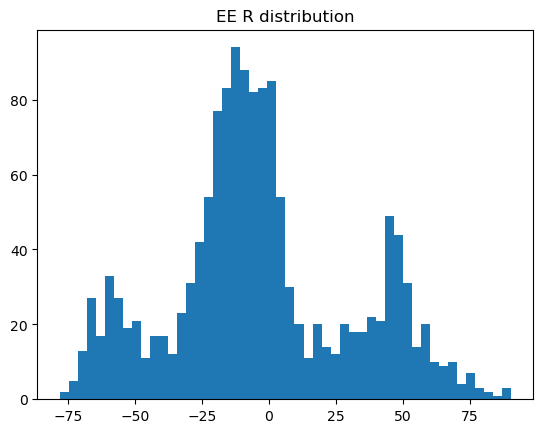

In [4]:
plt.title('EE R distribution')
plt.hist(df['ee_R'], bins=50)
plt.show()

In [5]:
df['ee_R'].quantile(0.9)

np.float64(47.38999938964844)

In [6]:
reactant_1_pool = df['reactant_1'].unique()
catalyst_1_pool = df['catalyst_1'].unique()
catalyst_2_pool = df['catalyst_2'].unique()

print(f'Total combination count: {len(reactant_1_pool) * len(catalyst_1_pool) * len(catalyst_2_pool)} (size of the dataset:{len(df)})')

Total combination count: 1430 (size of the dataset:1430)


In [7]:
fpgen = GetMorganGenerator(radius=2,fpSize=1024)

reactant_1_descriptors = SmilesToDescriptors(fpgen, reactant_1_pool)
catalyst_1_descriptors = SmilesToDescriptors(fpgen, catalyst_1_pool)
catalyst_2_descriptors = SmilesToDescriptors(fpgen, catalyst_2_pool, sanitize=False)

reactant_1_descriptors.head(3)

,33,46,64,90,114,125,133,136,145,175,...,799,809,816,831,841,896,904,909,940,961
c1ccc(C(=O)CBr)cc1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
Cc1ccc(C(=O)CBr)cc1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
Oc1ccc(C(=O)CBr)cc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
from baybe.targets import NumericalTarget
from baybe.objectives import SingleTargetObjective
from baybe.parameters import CustomDiscreteParameter, SubstanceParameter
from baybe.searchspace import SearchSpace

reactant_1_param = CustomDiscreteParameter(
    name='reactant_1',
    data=reactant_1_descriptors,
    decorrelate=True,
)

catalyst_1_param = CustomDiscreteParameter(
    name='catalyst_1',
    data=catalyst_1_descriptors,
    decorrelate=True,
)

catalyst_2_param = CustomDiscreteParameter(
    name='catalyst_2',
    data=catalyst_2_descriptors,
    decorrelate=True,
)

parameters = [
    reactant_1_param,
    catalyst_1_param,
    catalyst_2_param,
]

searchspace = SearchSpace.from_product(parameters)

target = NumericalTarget(
    name="ee_R",
    mode="MAX",
)

objective = SingleTargetObjective(target=target)

df_lookup = df[['reactant_1', 'catalyst_1', 'catalyst_2', 'ee_R']]
df_lookup.head(2)

#print(searchspace)

,reactant_1,catalyst_1,catalyst_2,ee_R
0,c1ccc(C(=O)CBr)cc1,C1COCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,0.63
1,c1ccc(C(=O)CBr)cc1,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,44.66


In [9]:
from baybe import Campaign
from baybe.simulation import simulate_scenarios
from baybe.recommenders import (
    BotorchRecommender,
    FPSRecommender,
    TwoPhaseMetaRecommender,
    RandomRecommender,
    )

BATCH_SIZE = 1
N_DOE_ITERATIONS = 50
N_MC_ITERATIONS = 5


lookup = df_lookup  # some reasonable lookup, e.g. a Callable

smart_recommender = TwoPhaseMetaRecommender(
    initial_recommender=RandomRecommender(),  # farthest point sampling
    recommender=BotorchRecommender(),  # Bayesian model-based optimization
    )


random_recommender = TwoPhaseMetaRecommender(
  initial_recommender=RandomRecommender(), 
  recommender=RandomRecommender()
  )

smart_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=smart_recommender)
random_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=random_recommender)

scenarios = {"Smart": smart_campaign, "Random": random_campaign}

results = simulate_scenarios(
    scenarios,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|##########| 10/10 [02:41<00:00, 16.11s/it]


Text(0.5, 1.0, 'Smart vs Random')

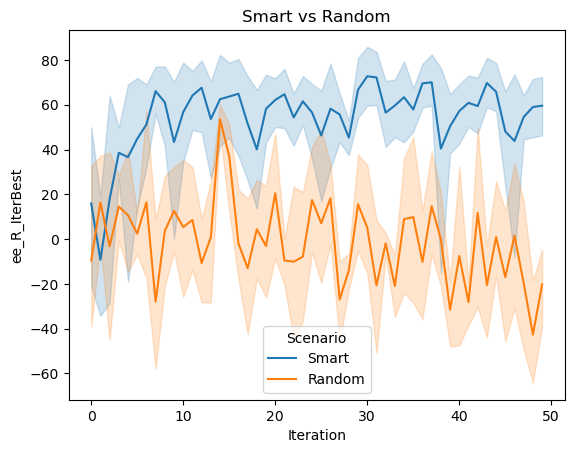

In [15]:
sns.lineplot(data=results, x='Iteration', y='ee_R_IterBest', hue='Scenario')
plt.title('Smart vs Random')

In [11]:
results

,Scenario,Monte_Carlo_Run,Iteration,Num_Experiments,ee_R_Measurements,ee_R_IterBest,ee_R_CumBest
0,Smart,0,0,1,[60.880001068115234],60.880001,60.880001
1,Smart,0,1,2,[-16.43000030517578],-16.430000,60.880001
2,Smart,0,2,3,[-43.91999816894531],-43.919998,60.880001
3,Smart,0,3,4,[21.940000534057617],21.940001,60.880001
4,Smart,0,4,5,[63.91999816894531],63.919998,63.919998
...,...,...,...,...,...,...,...
495,Random,4,45,46,[-28.190000534057617],-28.190001,84.510002
496,Random,4,46,47,[-58.27999877929688],-58.279999,84.510002
497,Random,4,47,48,[-15.539999961853027],-15.540000,84.510002
498,Random,4,48,49,[-51.34999847412109],-51.349998,84.510002
